# Music Generation

### Importing necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav
import pandas as pd
import os
import numpy as np
import seaborn as sns


from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
import catboost as cb

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

## Dataset Exploration

In [ ]:
df = pd.read_csv('/kaggle/input/gtzan-3-sec/train.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,pop.00072.5.wav,66149,0.464264,0.079744,0.228116,0.007791,2156.231325,333455.342337,2295.327890,301528.295866,...,36.512493,0.587634,44.336262,3.168914,31.690376,0.719836,50.416603,-3.192938,25.115688,pop
1,jazz.00038.9.wav,66149,0.254604,0.090115,0.075960,0.002236,1439.715643,68955.697954,1532.279764,78968.523547,...,29.887444,-0.706779,105.123726,2.879812,157.346725,3.201282,71.674042,-1.664307,53.640949,jazz
2,disco.00055.3.wav,66149,0.488070,0.065943,0.119709,0.001558,2049.831819,132030.817465,2043.472368,71699.726714,...,29.158789,-4.570374,24.995367,-0.735507,33.519482,-2.301054,38.444759,6.482006,50.393089,disco
3,rock.00025.9.wav,66149,0.440747,0.071972,0.108535,0.001491,2237.056815,129862.001264,2070.706749,62747.206984,...,33.833458,-5.574619,29.497013,3.903063,18.930311,-2.205716,26.832264,0.551784,25.199505,rock
4,jazz.00013.4.wav,66149,0.369718,0.090648,0.052010,0.000124,1775.591113,66645.168399,2351.155395,51753.800714,...,48.042686,-3.686353,47.710155,3.593751,70.004326,0.011506,85.980957,1.892704,108.339722,jazz


In [ ]:
df.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,8991.0,8991.000000,8991.000000,8991.000000,8.991000e+03,8991.000000,8.991000e+03,8991.000000,8.991000e+03,8991.000000,...,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,66149.0,0.379429,0.084906,0.131079,2.692355e-03,2202.499294,4.180213e+05,2243.675807,1.182854e+05,4573.851725,...,1.447258,49.903670,-4.167124,52.012612,0.762790,52.587622,-2.493215,55.144385,-0.909010,57.501708
std,0.0,0.090370,0.009649,0.068530,3.609881e-03,755.453076,4.368142e+05,546.167312,1.015757e+05,1648.815846,...,5.751630,33.659602,5.697644,36.159784,5.191410,38.360354,5.127533,41.979298,5.286712,46.882536
min,66149.0,0.107108,0.015345,0.000953,4.379535e-08,472.741636,8.118813e+02,499.162910,1.183520e+03,658.336276,...,-26.850016,1.325786,-24.810783,1.624544,-20.733809,3.437439,-23.676704,3.065302,-35.640659,0.282131
25%,66149.0,0.315718,0.079894,0.083768,6.191782e-04,1630.687076,1.232141e+05,1887.668895,4.872991e+04,3385.889141,...,-2.234193,29.608310,-7.948629,29.862267,-2.445160,29.669745,-5.734310,30.503081,-4.015092,30.086961
50%,66149.0,0.384857,0.085147,0.121635,1.496367e-03,2209.805128,2.666254e+05,2232.301304,8.992711e+04,4636.595553,...,1.488159,41.794029,-4.412789,42.266727,0.768402,41.915512,-2.699601,43.447445,-1.033373,44.516968
75%,66149.0,0.442305,0.091105,0.176834,3.168995e-03,2717.143710,5.636267e+05,2595.771961,1.587088e+05,5604.802903,...,5.142493,59.088749,-0.697015,61.809235,3.902450,62.243496,0.516225,65.669441,2.218058,68.463200
max,66149.0,0.749481,0.120964,0.442567,3.261522e-02,5432.534406,4.794119e+06,3708.147554,1.235143e+06,9487.446477,...,39.144405,683.932556,34.048843,434.345642,36.970322,629.729797,31.365425,1143.230591,34.212101,910.473206


In [ ]:
print(df.shape)
df.info()

(8991, 60)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 8991 non-null   object 
 1   length                   8991 non-null   int64  
 2   chroma_stft_mean         8991 non-null   float64
 3   chroma_stft_var          8991 non-null   float64
 4   rms_mean                 8991 non-null   float64
 5   rms_var                  8991 non-null   float64
 6   spectral_centroid_mean   8991 non-null   float64
 7   spectral_centroid_var    8991 non-null   float64
 8   spectral_bandwidth_mean  8991 non-null   float64
 9   spectral_bandwidth_var   8991 non-null   float64
 10  rolloff_mean             8991 non-null   float64
 11  rolloff_var              8991 non-null   float64
 12  zero_crossing_rate_mean  8991 non-null   float64
 13  zero_crossing_rate_var   8991 non-null   float64
 14  harmony_mean 

## Data Visualization

### Histograms for Numeric Features

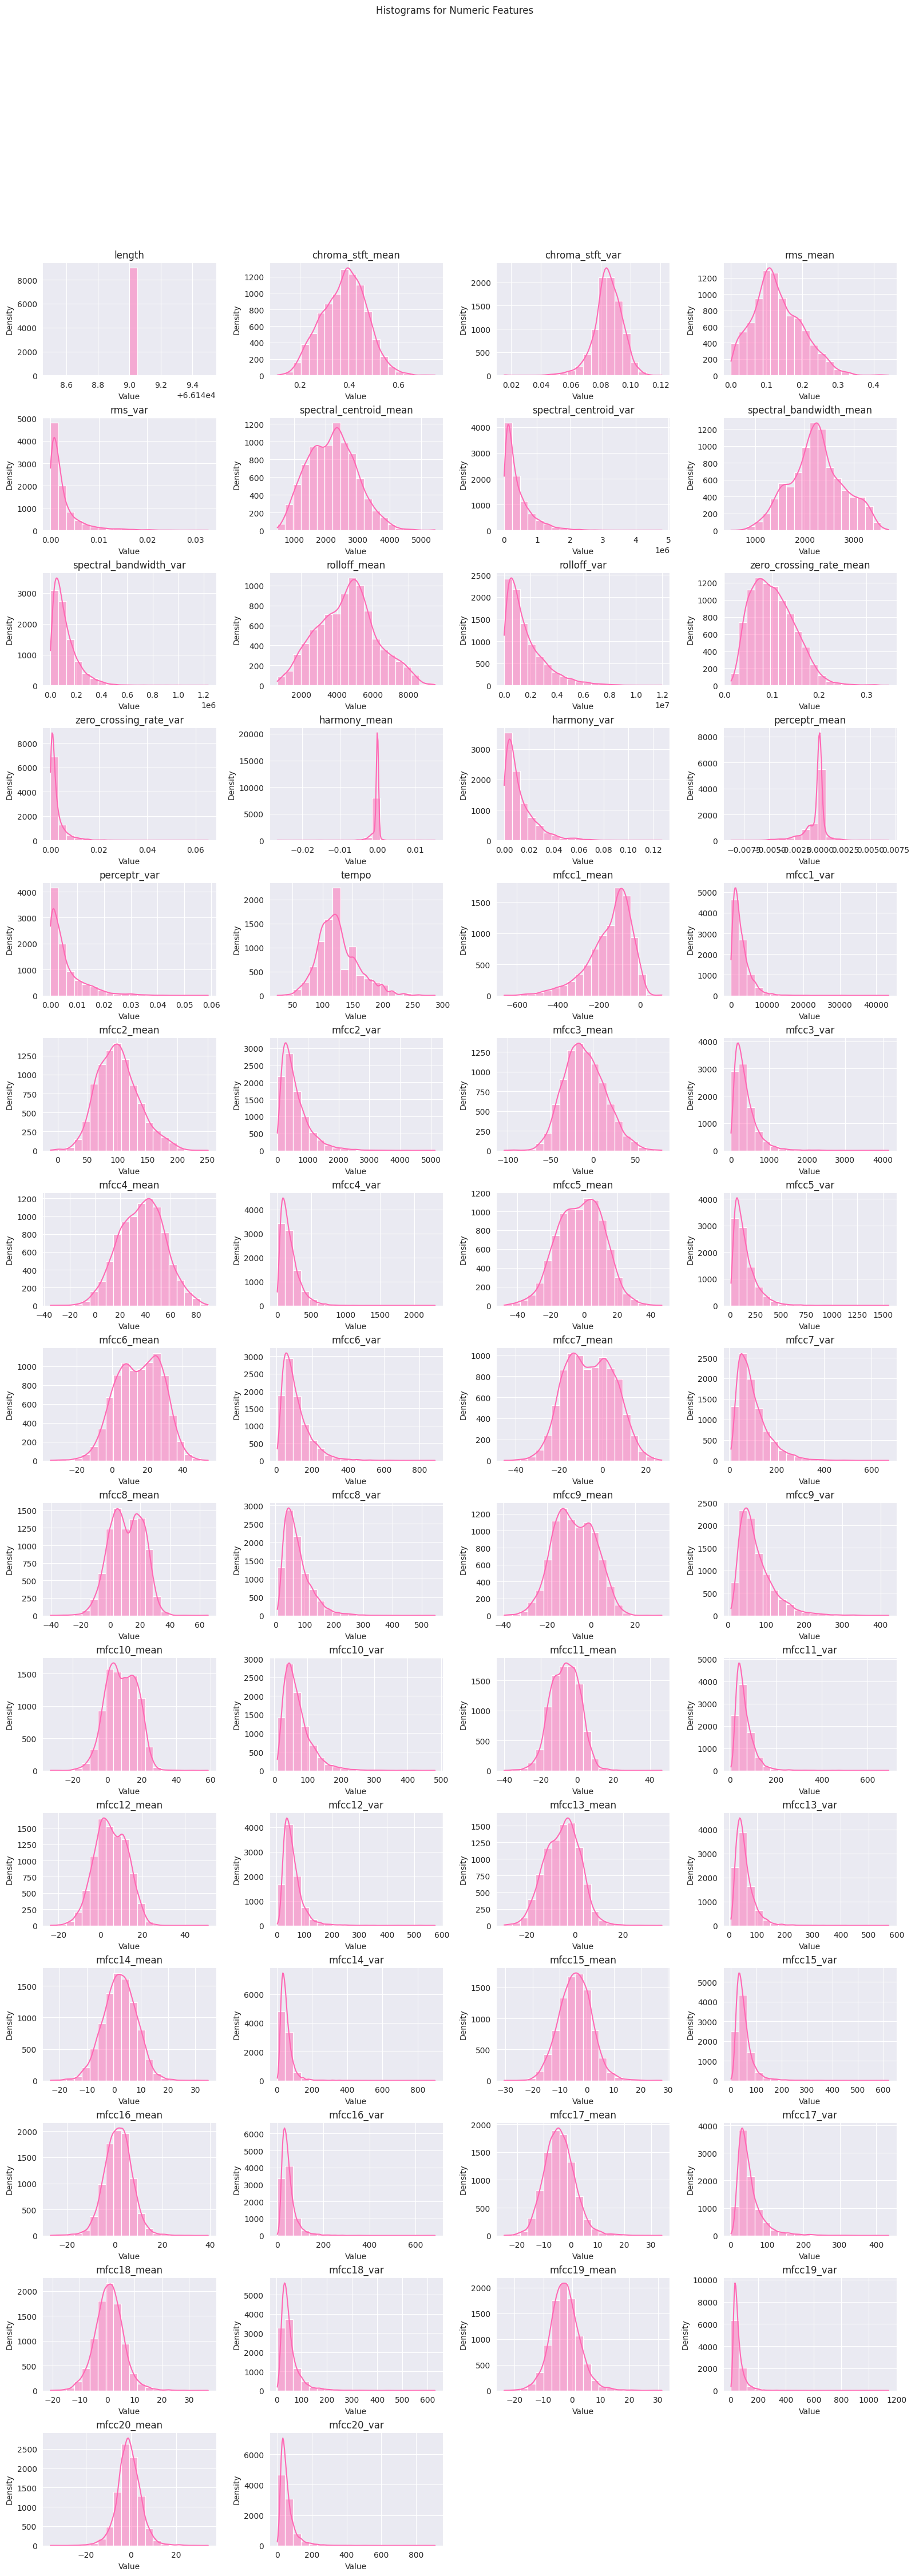

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a list of numeric features (excluding 'filename' and 'label')
numeric_features = df.drop(['filename', 'label'], axis=1).columns

# Set the number of columns and rows for the subplots
num_columns = 4  # Number of subplots per row
num_rows = int(np.ceil(len(numeric_features) / num_columns))

# Set Seaborn style to dark background
sns.set_style("darkgrid")

# Create a custom color palette ranging from pink to purple to dark purple
custom_palette = sns.color_palette(["#FF69B4", "#9370DB", "#4B0082"])

# Set the color palette
sns.set_palette(custom_palette)

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 3 * num_rows))
fig.suptitle("Histograms for Numeric Features", y=1)

# Loop through features and create histograms
for i, feature in enumerate(numeric_features):
    row, col = divmod(i, num_columns)
    ax = axes[row, col]
    sns.histplot(df[feature], bins=20, kde=True, ax=ax)
    ax.set_title(f"{feature}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")

# Remove any empty subplots
for i in range(len(numeric_features), num_columns * num_rows):
    fig.delaxes(axes[divmod(i, num_columns)])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### Bar Chart for Categorical Labels

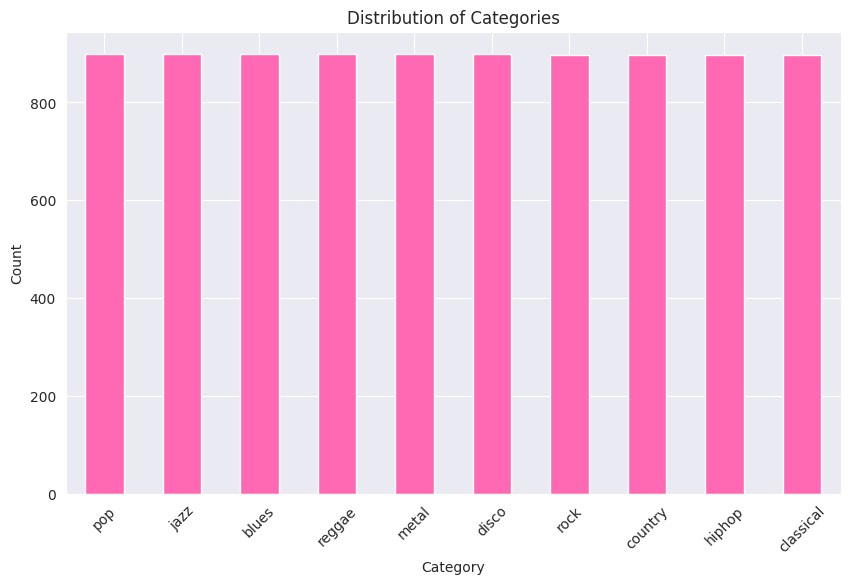

In [ ]:
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title("Distribution of Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


## Box Plots for Feature vs. Label

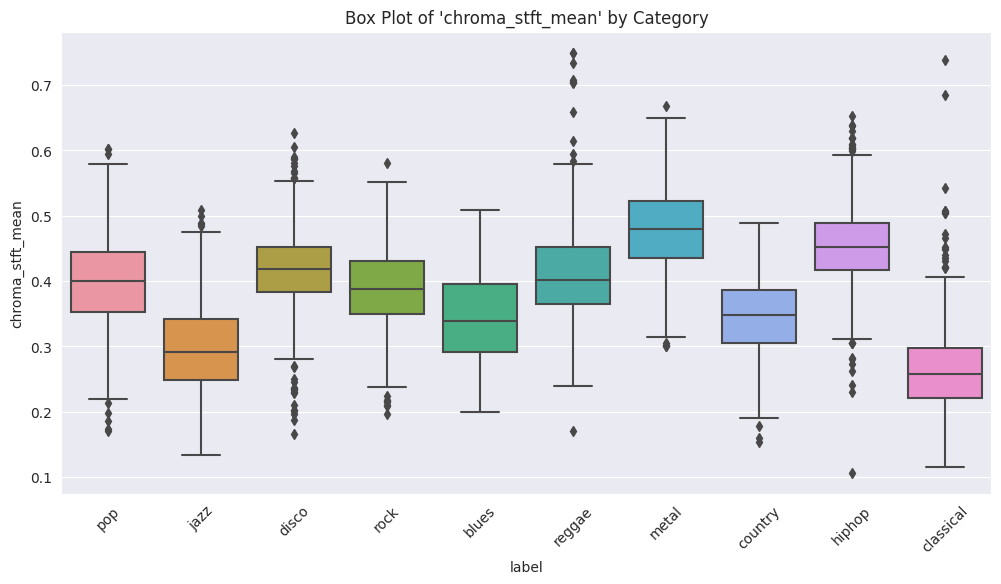

In [ ]:
#Outlier Detection
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='chroma_stft_mean', data=df)
plt.title("Box Plot of 'chroma_stft_mean' by Category")
plt.xticks(rotation=45)
plt.show()


## Correlation Heatmap

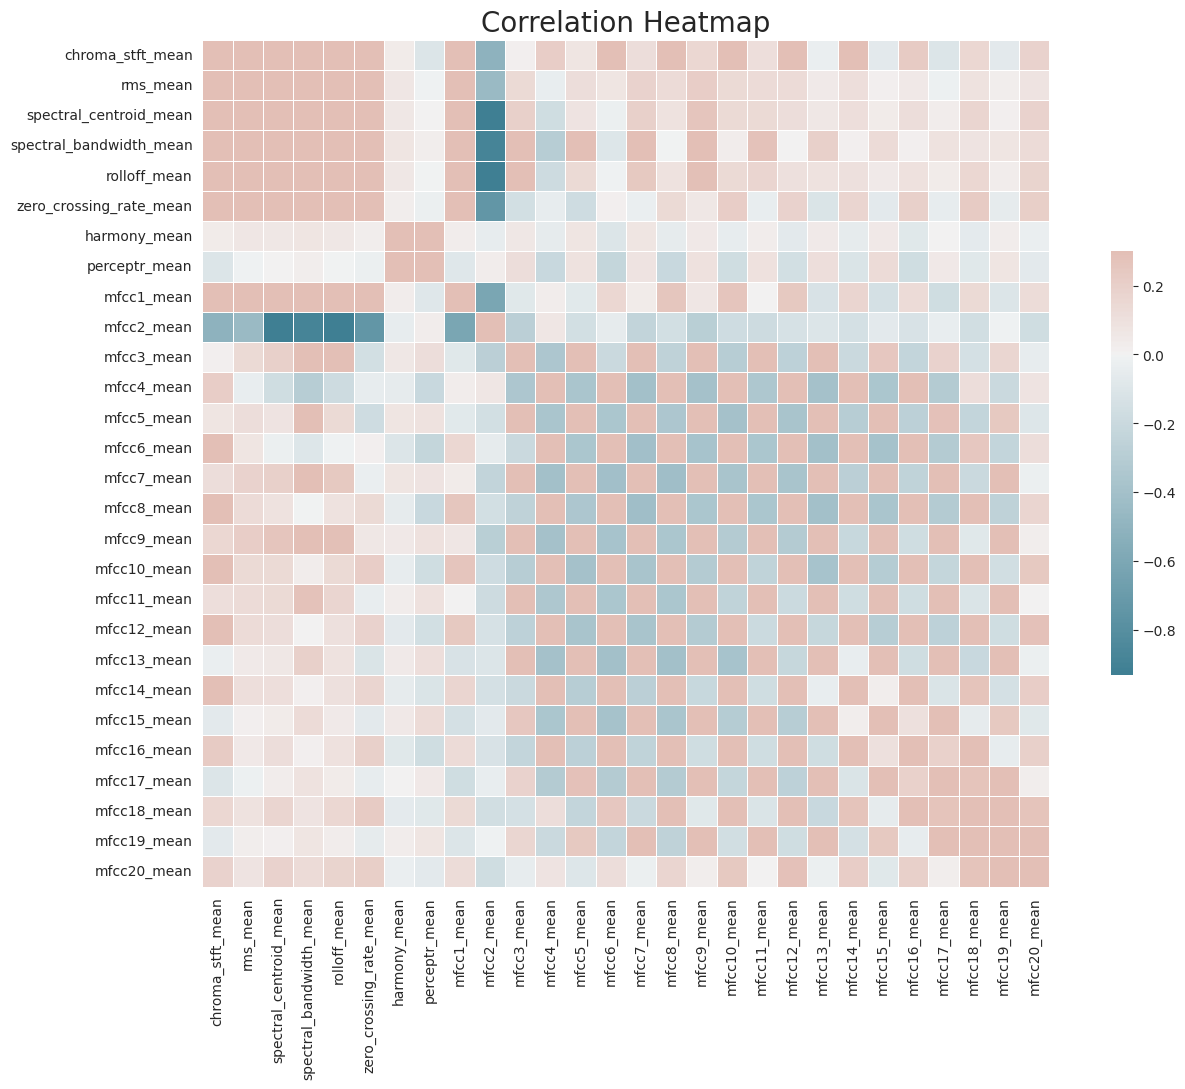

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11))

# Define a custom color map (choose a colormap that you prefer)
custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)  # Example color map

# Draw the heatmap with the custom color map
sns.heatmap(corr, cmap=custom_cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("Corr_Heatmap.png")


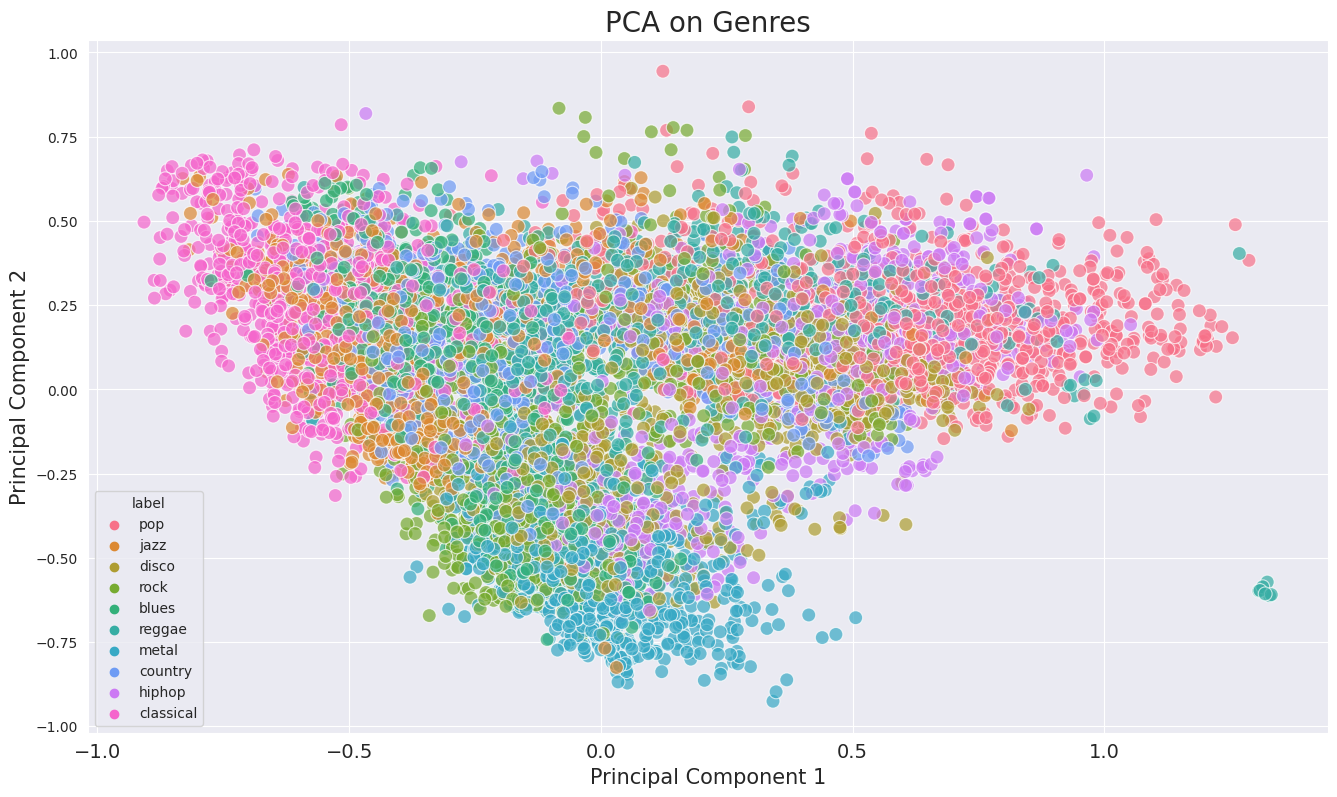

In [ ]:
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp


data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

In [ ]:
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


In [ ]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'pop': 0, 'jazz': 1, 'disco': 2, 'rock': 3, 'blues': 4, 'reggae': 5, 'metal': 6, 'country': 7, 'hiphop': 8, 'classical': 9}
{0: 'pop', 1: 'jazz', 2: 'disco', 3: 'rock', 4: 'blues', 5: 'reggae', 6: 'metal', 7: 'country', 8: 'hiphop', 9: 'classical'}
